In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
import pickle
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
target = 'Coeff_C'

# Standard Scaling

In [6]:
df_test = pd.read_csv('scaled_standard_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_standard_'+target+'_train.csv', encoding='cp1252')  

In [7]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_C'], dtype=object)

In [8]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_C'], dtype=object)

In [9]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [10]:
with open("standard_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [11]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)

# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.9211408590796967
RMSE:  0.24555541176658788
RMSE unscaled:  0.009262561903778105
----------------------------------------


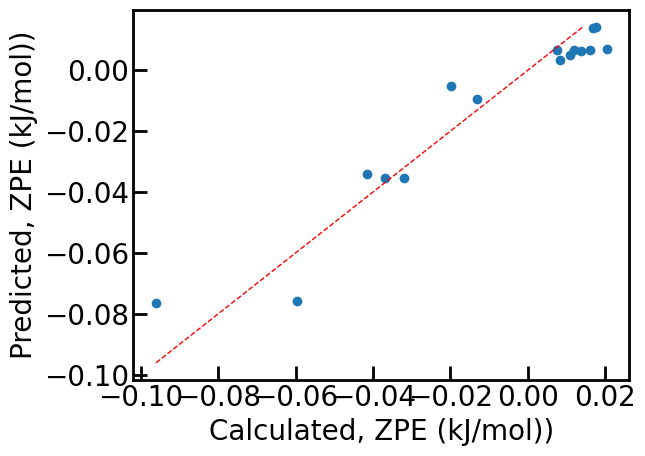

GB 0.9152164084621566
RMSE:  0.25461230821820574
RMSE unscaled:  0.0096041958487834
----------------------------------------


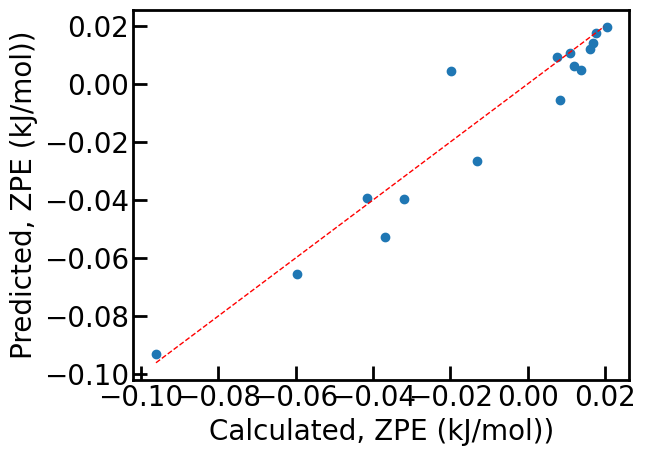

RR 0.9539054970515989
RMSE:  0.1877362147994536
RMSE unscaled:  0.007081571929735547
----------------------------------------


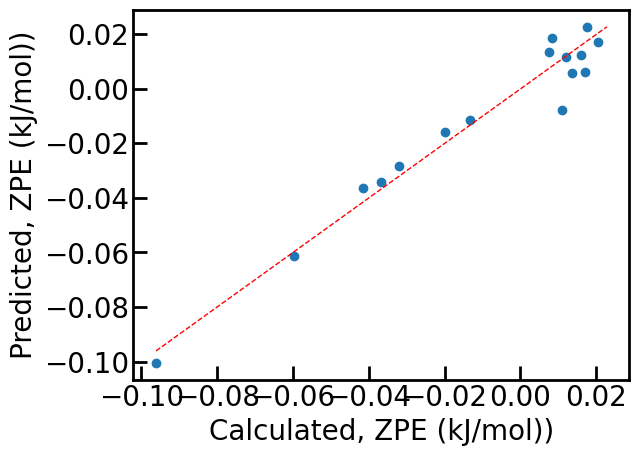

LASSO 0.962754571530962
RMSE:  0.1687562928627261
RMSE unscaled:  0.006365632905614493
----------------------------------------


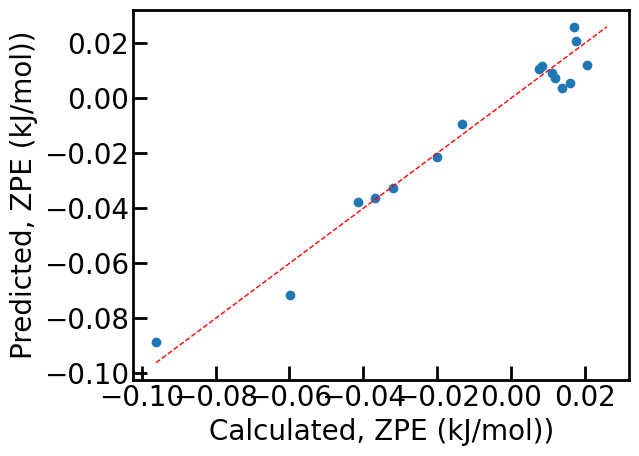

gpr1 0.9777931205490619
RMSE:  0.13030685307092843
RMSE unscaled:  0.004915286877095099
----------------------------------------


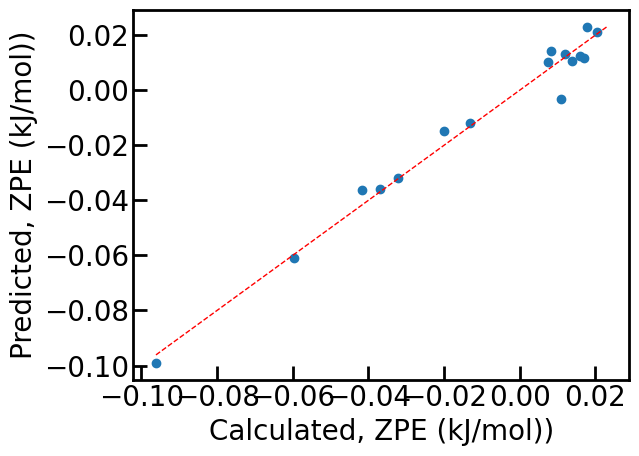

gpr2 0.9815757992807307
RMSE:  0.11869100776123002
RMSE unscaled:  0.0044771271742738705
----------------------------------------


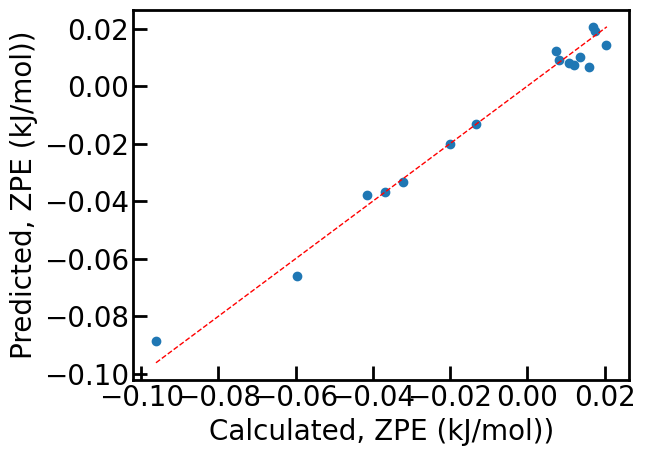

gpr3 0.9759956233975877
RMSE:  0.1354779776250704
RMSE unscaled:  0.005110346154959503
----------------------------------------


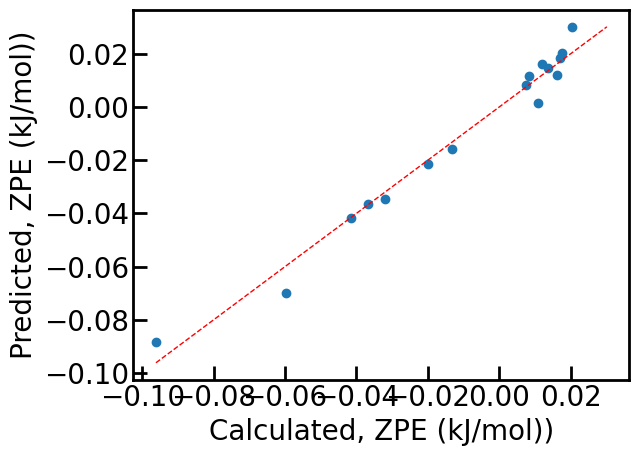

gpr4 0.9898156074602202
RMSE:  0.08824519236806246
RMSE unscaled:  0.003328684760557999
----------------------------------------


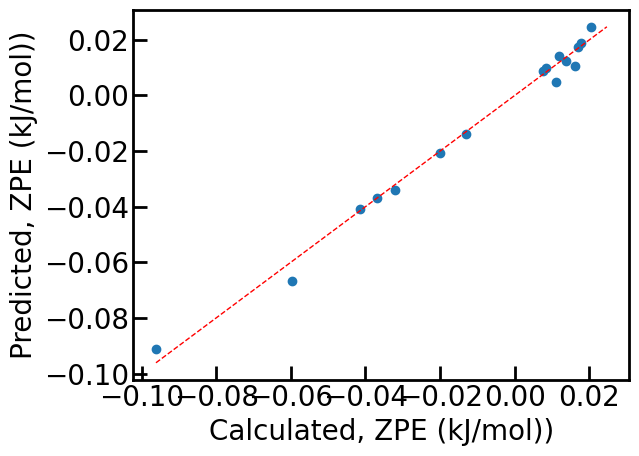

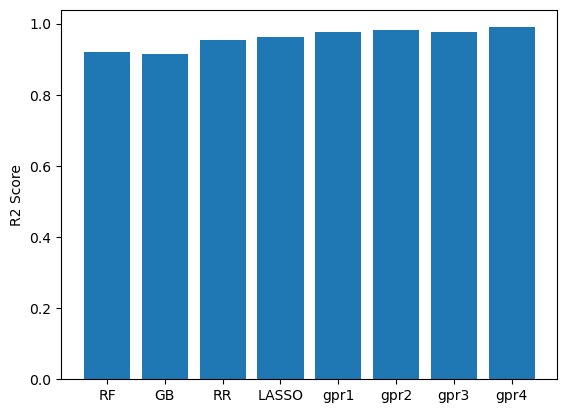

In [12]:
run_models()

In [13]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  304.626316
23    X_IEII  236.795503
14       X_Z  170.238631
4   mean_X2X  124.838656
2   mean_A2X   77.660541
34    X_Rvdw   59.597995
32    A_Rvdw   36.345858
26      X_EA   35.663299
9      E_coh   34.613752
47   X_Kappa   32.665402
46   B_Kappa   24.049675
18     A_IEI   20.916890
30    A_ChiA   18.393248
20     X_IEI   17.961665
25      B_EA   14.810073
43      X_MV   13.218705
29    X_ChiP   12.711918
6    std_A2X   12.381552
12       A_Z   10.101920
27    A_ChiP    9.324037
45   A_Kappa    7.987752
37      A_MP    7.760008
28    B_ChiP    6.612120
7    std_B2X    6.500297
13       B_Z    6.375766
38      B_MP    6.004889
48     A_CvM    5.906049
24      A_EA    5.775107
40     B_Rho    5.697231
19     B_IEI    5.567722


In [14]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_IEII', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa', 'B_Kappa', 'A_IEI', 'A_ChiA',
       'X_IEI', 'B_EA', 'X_MV', 'X_ChiP', 'std_A2X', 'A_Z', 'A_ChiP',
       'A_Kappa', 'A_MP', 'B_ChiP', 'std_B2X', 'B_Z', 'B_MP', 'A_CvM',
       'A_EA', 'B_Rho', 'B_IEI', 'B_Hf', 'density', 'A_B', 'OF', 'A_G',
       'TF', 'X_Rho', 'B_MV', 'std_A2B', 'B_CvM'], dtype=object)

In [15]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9111370954513482
RMSE:  0.2606656120864598
RMSE unscaled:  0.009832531691185354
----------------------------------------


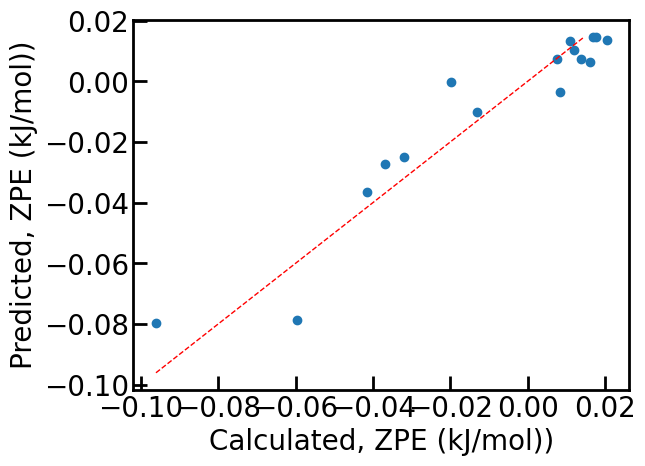

GB 0.936987070542855
RMSE:  0.21950192045160907
RMSE unscaled:  0.008279801742320438
----------------------------------------


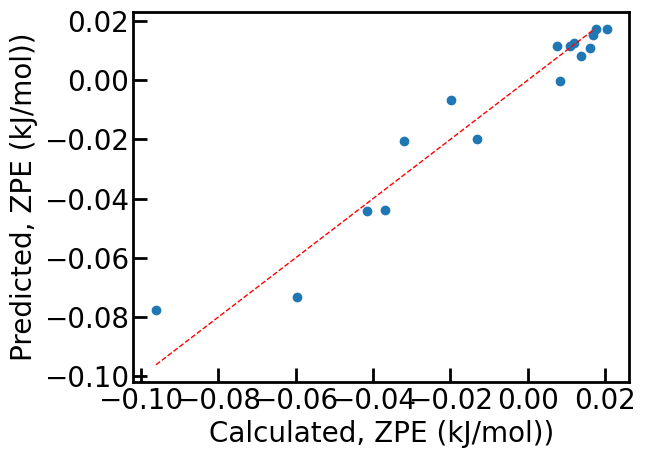

RR 0.9800363812435198
RMSE:  0.12355010616450345
RMSE unscaled:  0.004660416556629865
----------------------------------------


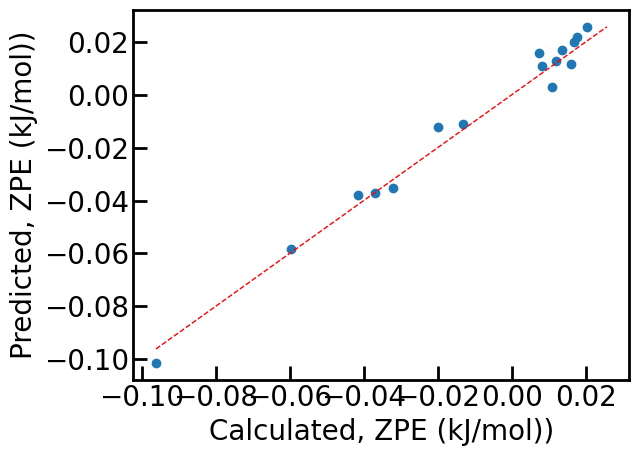

LASSO 0.962010298532006
RMSE:  0.1704340756334984
RMSE unscaled:  0.006428920318681744
----------------------------------------


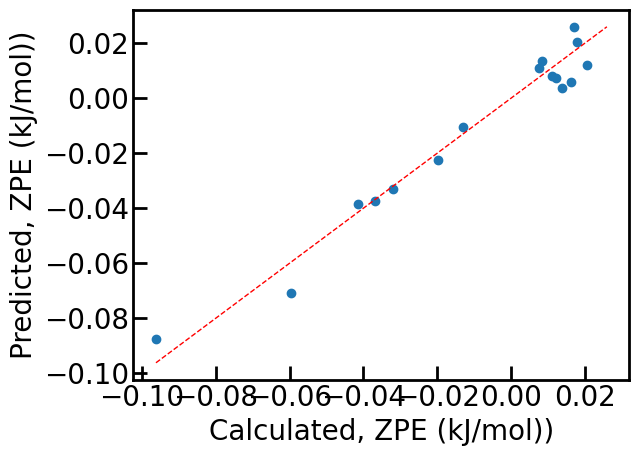

gpr1 0.9825494690493797
RMSE:  0.11551218842206035
RMSE unscaled:  0.004357219367322446
----------------------------------------


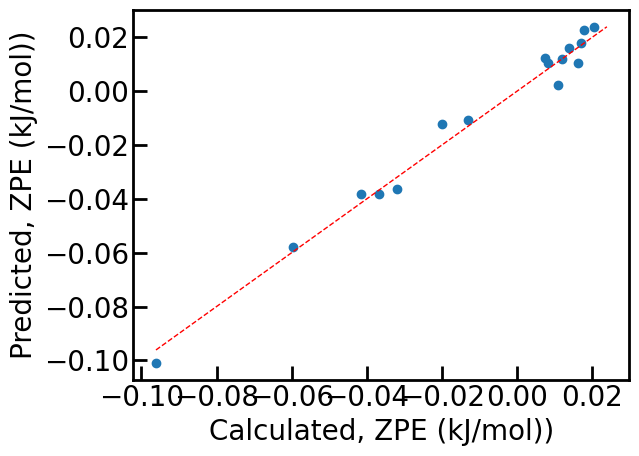

gpr2 0.9836921332561522
RMSE:  0.11166628454157244
RMSE unscaled:  0.004212148556165325
----------------------------------------


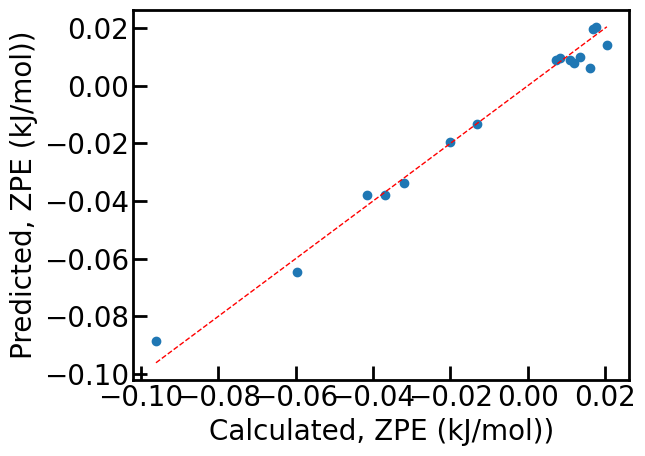

gpr3 0.9783409312146066
RMSE:  0.12868957878764356
RMSE unscaled:  0.004854281896359616
----------------------------------------


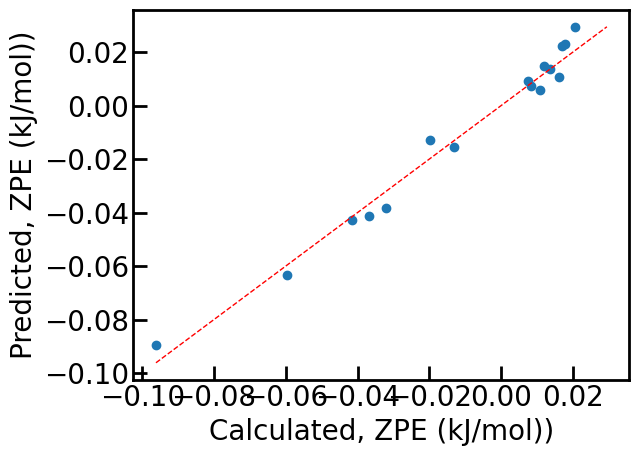

gpr4 0.9908871751499215
RMSE:  0.08347376468111634
RMSE unscaled:  0.0031487023932308678
----------------------------------------


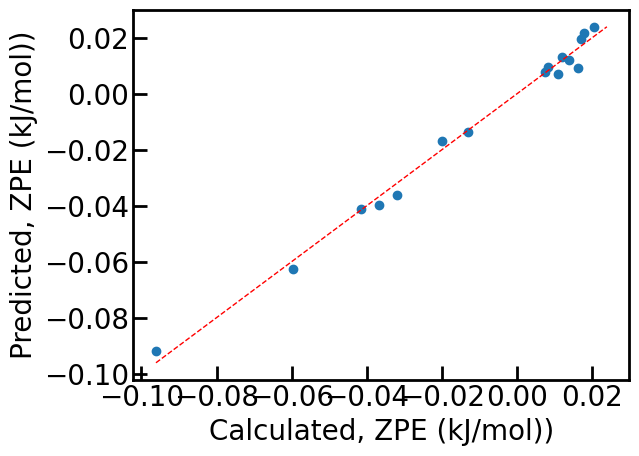

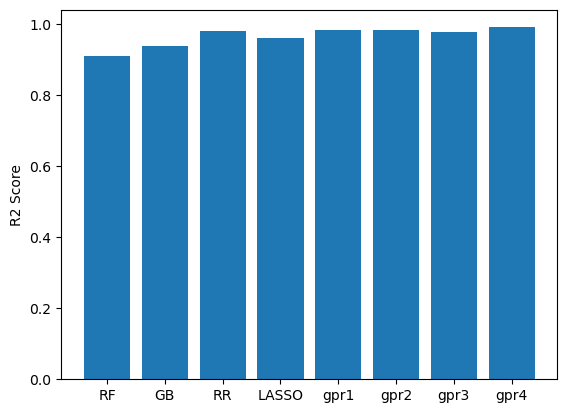

In [16]:
run_models()

In [17]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_IEII', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa', 'B_Kappa', 'A_IEI', 'A_ChiA',
       'X_IEI', 'B_EA', 'X_MV', 'X_ChiP', 'std_A2X', 'A_Z', 'A_ChiP',
       'A_Kappa', 'A_MP', 'B_ChiP', 'std_B2X', 'B_Z', 'B_MP', 'A_CvM',
       'A_EA', 'B_Rho', 'B_IEI'], dtype=object)

In [18]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9442652291184281
RMSE:  0.2064365532011608
RMSE unscaled:  0.007786964821797151
----------------------------------------


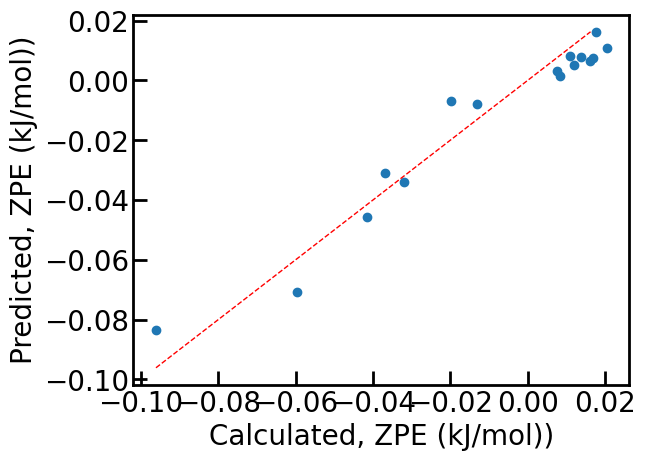

GB 0.9411978962743941
RMSE:  0.21204103775094063
RMSE unscaled:  0.007998370812435422
----------------------------------------


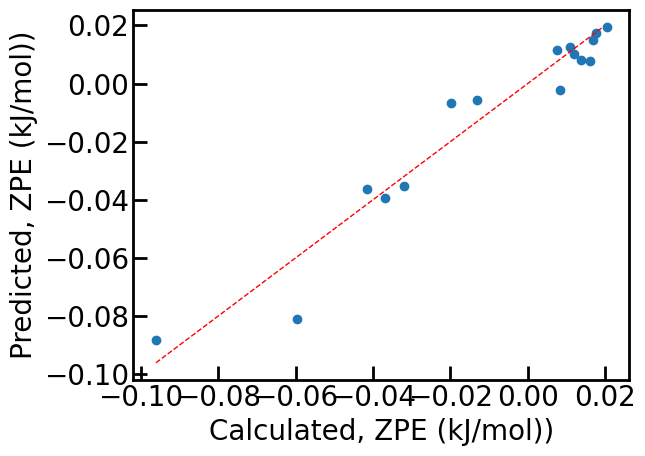

RR 0.9728399718480877
RMSE:  0.1441081679463449
RMSE unscaled:  0.005435884376728266
----------------------------------------


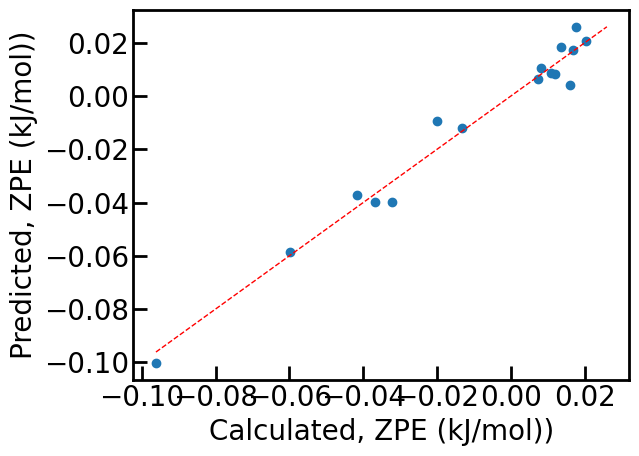

LASSO 0.9636792039226678
RMSE:  0.1666484077480848
RMSE unscaled:  0.006286121661207562
----------------------------------------


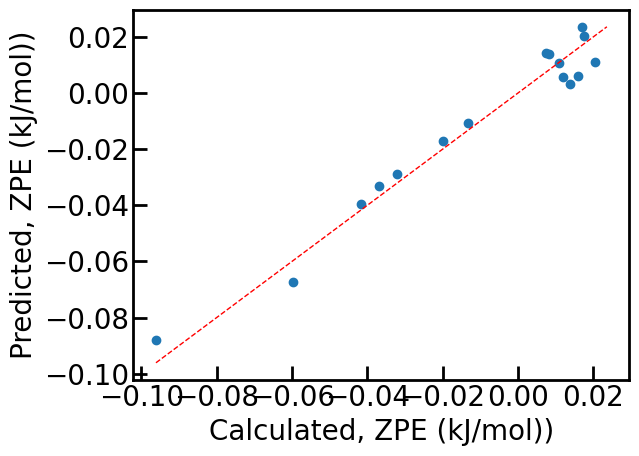

gpr1 0.9750038545152048
RMSE:  0.13824836728604223
RMSE unscaled:  0.00521484764221131
----------------------------------------


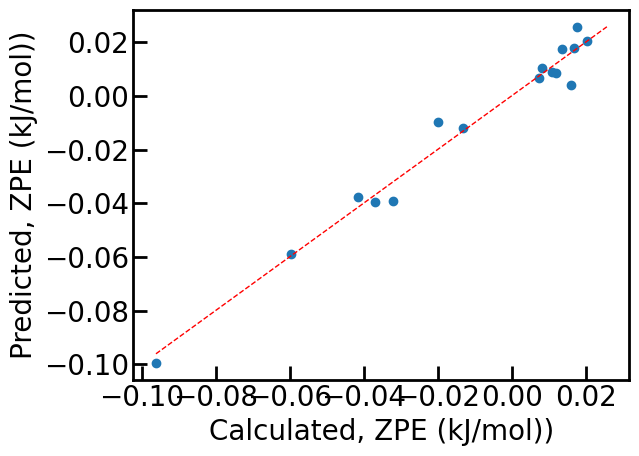

gpr2 0.9775236794255077
RMSE:  0.13109499097043406
RMSE unscaled:  0.004945016118370481
----------------------------------------


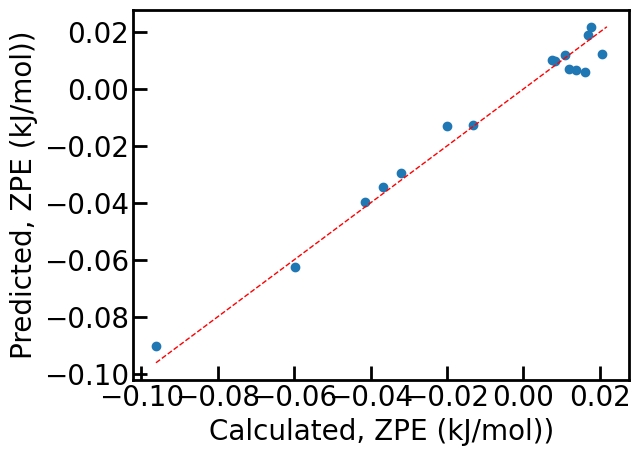

gpr3 0.973223872988243
RMSE:  0.1430860743878381
RMSE unscaled:  0.005397330126227278
----------------------------------------


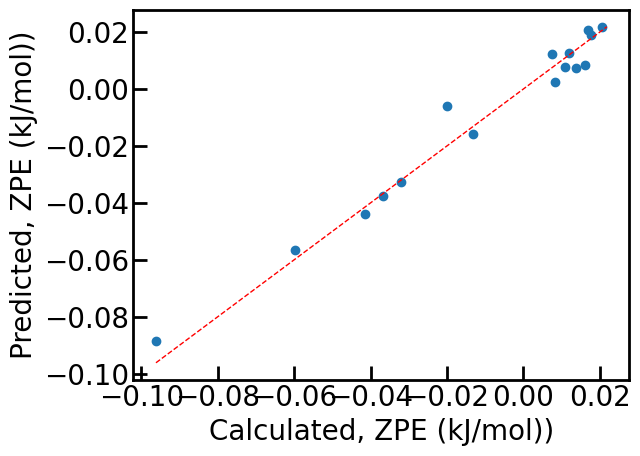

gpr4 0.9846825862605281
RMSE:  0.10822216324373166
RMSE unscaled:  0.00408223333053106
----------------------------------------


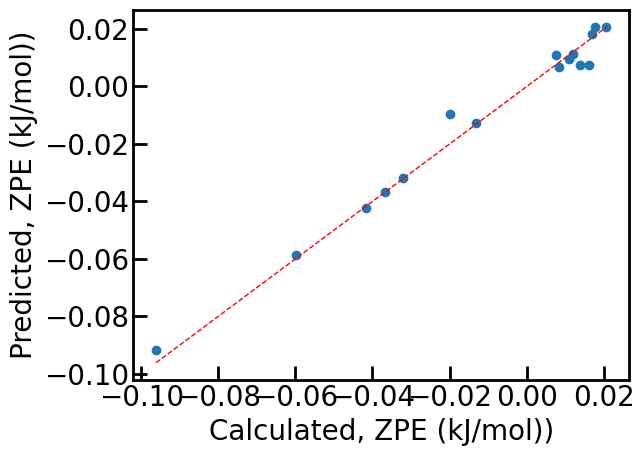

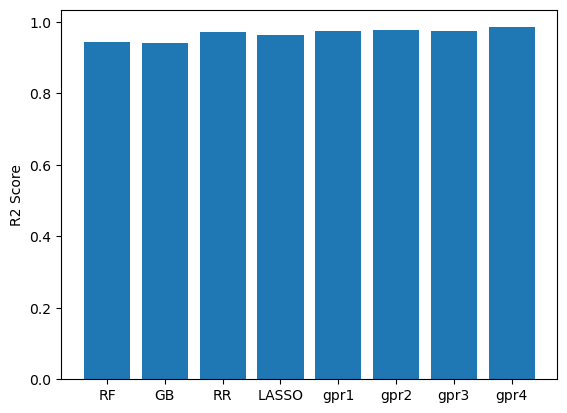

In [19]:
run_models()

In [20]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_IEII', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa', 'B_Kappa', 'A_IEI', 'A_ChiA',
       'X_IEI', 'B_EA', 'X_MV', 'X_ChiP', 'std_A2X', 'A_Z', 'A_ChiP'],
      dtype=object)

In [21]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9322369830558345
RMSE:  0.22762494602865907
RMSE unscaled:  0.008586209272547943
----------------------------------------


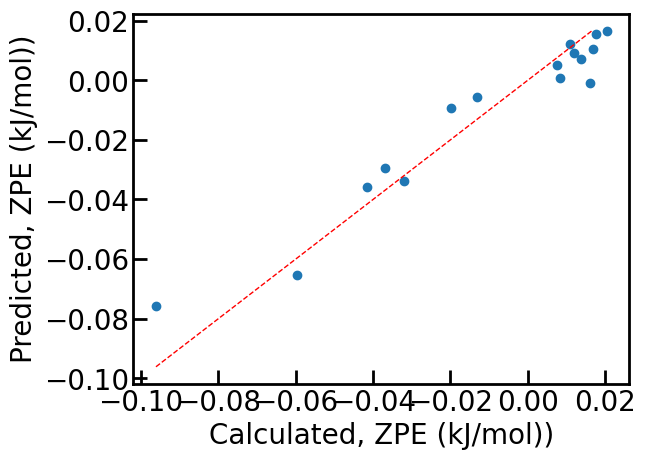

GB 0.8535551269598118
RMSE:  0.3346266880668646
RMSE unscaled:  0.012622407262690682
----------------------------------------


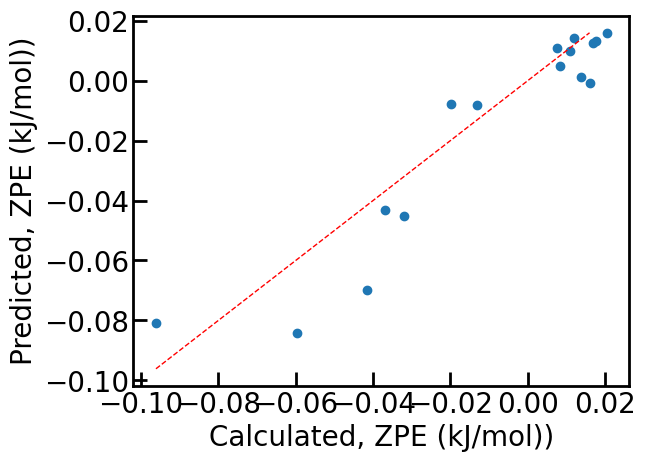

RR 0.960153615846374
RMSE:  0.17454923426454078
RMSE unscaled:  0.006584147651240508
----------------------------------------


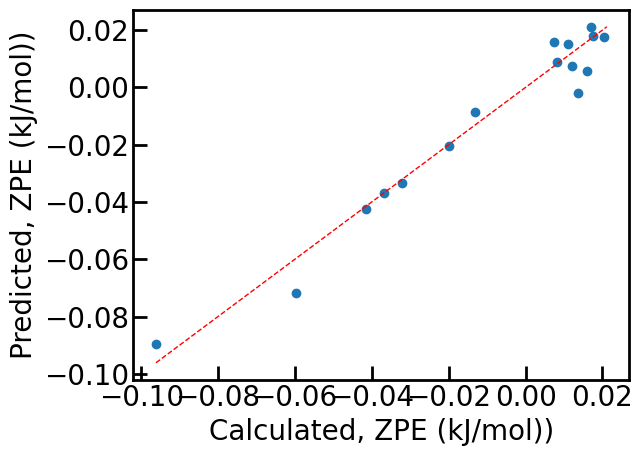

LASSO 0.9486911637821529
RMSE:  0.1980703966086716
RMSE unscaled:  0.007471386179986184
----------------------------------------


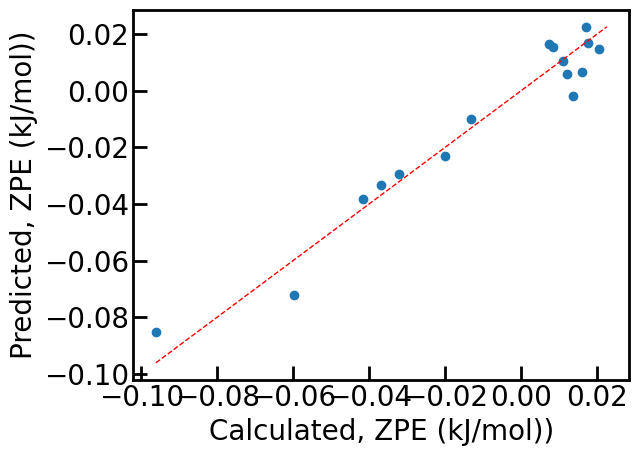

gpr1 0.9607524913897977
RMSE:  0.17323256497440528
RMSE unscaled:  0.006534481750094431
----------------------------------------


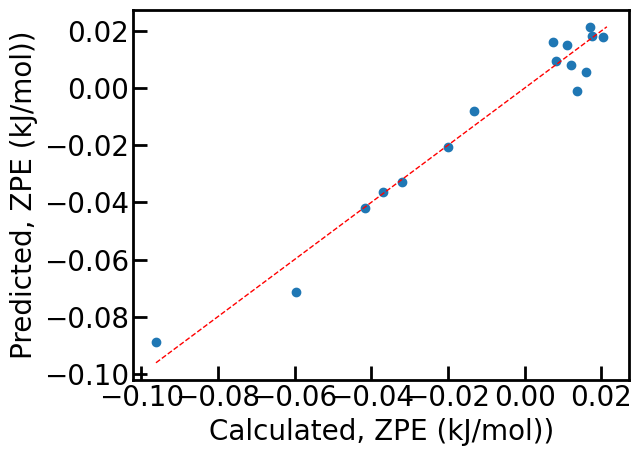

gpr2 0.9581193866656229
RMSE:  0.17894930076087648
RMSE unscaled:  0.00675012195418843
----------------------------------------


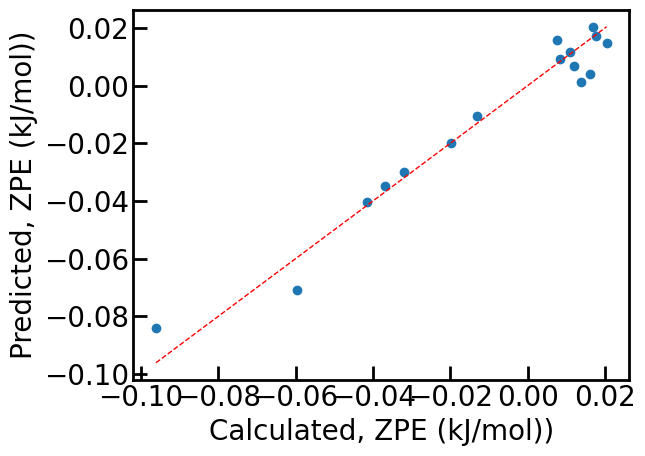

gpr3 0.9666133470907856
RMSE:  0.15977540615714075
RMSE unscaled:  0.006026866113781884
----------------------------------------


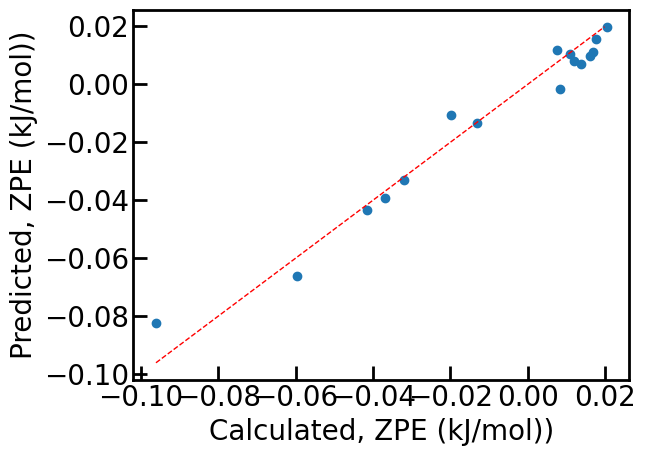

gpr4 0.9711765298009115
RMSE:  0.148455612916748
RMSE unscaled:  0.005599873750336144
----------------------------------------


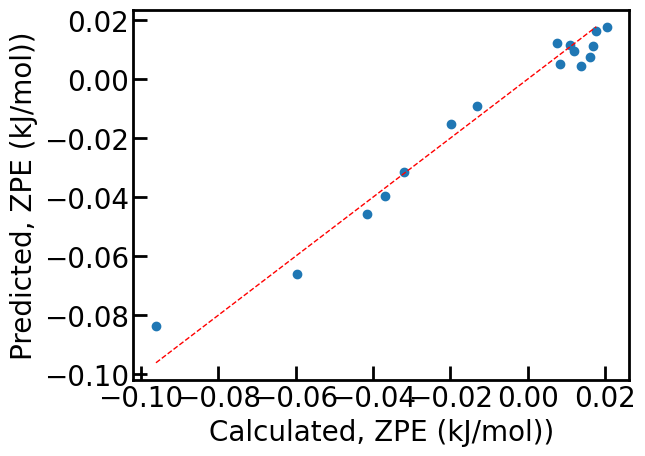

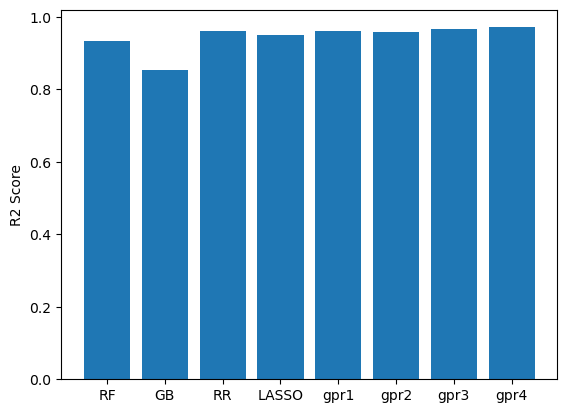

In [22]:
run_models()

In [23]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_IEII', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa'], dtype=object)

In [24]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8630682729745276
RMSE:  0.3235754262517716
RMSE unscaled:  0.012205544136194173
----------------------------------------


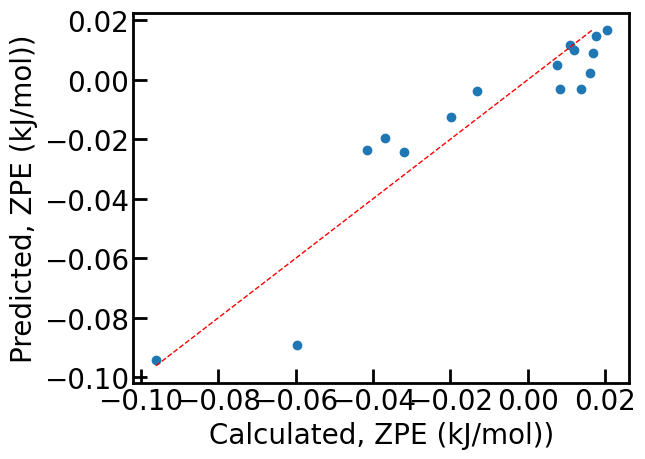

GB 0.8598892147936823
RMSE:  0.32730999886122836
RMSE unscaled:  0.012346415435793661
----------------------------------------


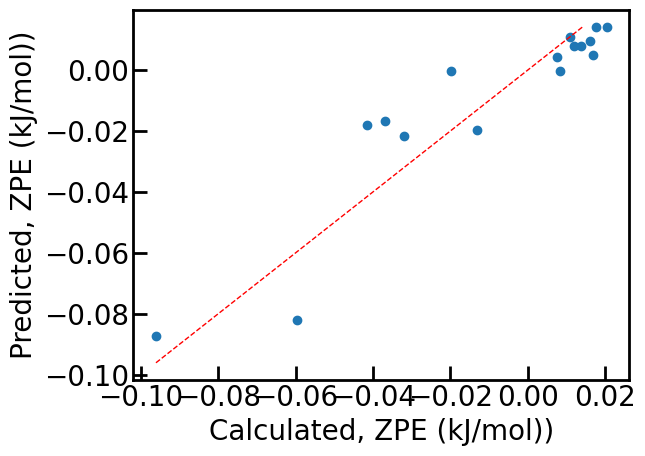

RR 0.8012785897958667
RMSE:  0.38980357634790674
RMSE unscaled:  0.014703727074313515
----------------------------------------


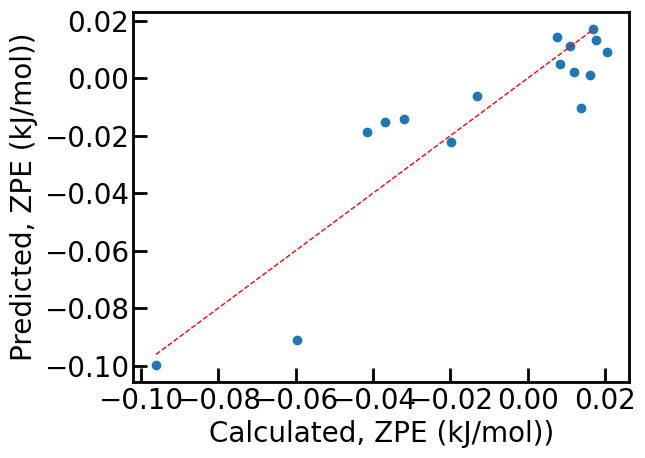

LASSO 0.8229635969148892
RMSE:  0.36792117011110365
RMSE unscaled:  0.013878303839232576
----------------------------------------


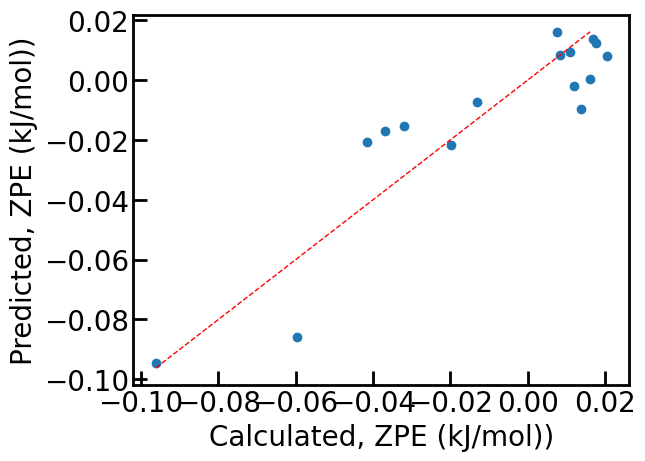

gpr1 0.802294172274402
RMSE:  0.3888062384920185
RMSE unscaled:  0.014666106630265116
----------------------------------------


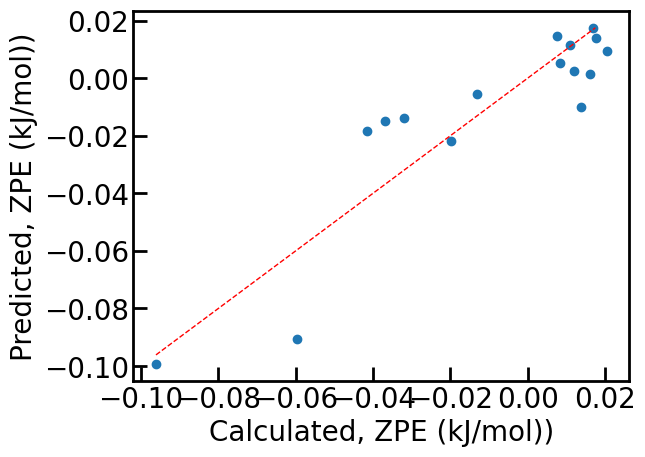

gpr2 0.8582906304273276
RMSE:  0.3291719135360735
RMSE unscaled:  0.012416648463081608
----------------------------------------


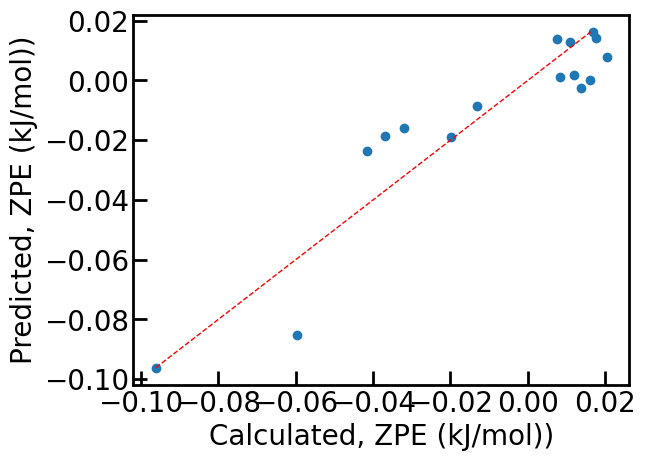

gpr3 0.9138314602049148
RMSE:  0.25668344290714945
RMSE unscaled:  0.00968232083543871
----------------------------------------


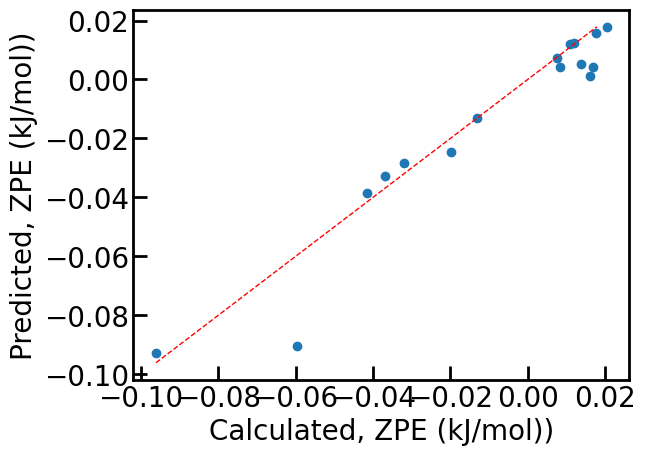

gpr4 0.922014670453877
RMSE:  0.2441911639617757
RMSE unscaled:  0.009211101300025755
----------------------------------------


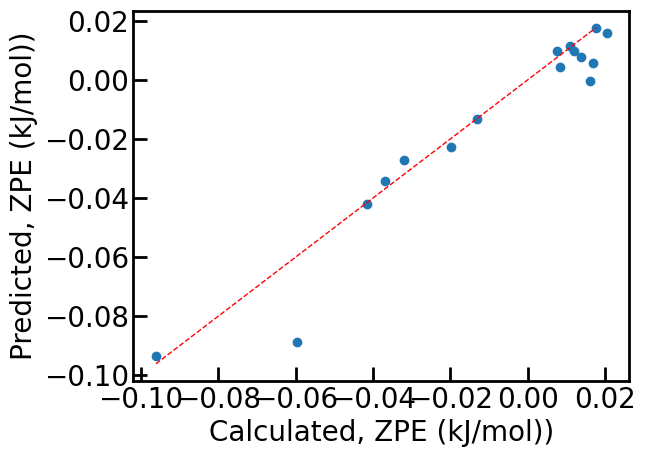

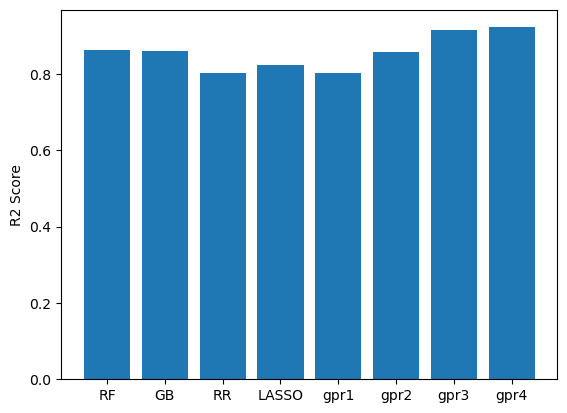

In [25]:
run_models()

# Min-Max scaling

In [26]:
df_test = pd.read_csv('scaled_minmax_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_minmax_'+target+'_train.csv', encoding='cp1252')   

In [27]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_C'], dtype=object)

In [28]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_C'], dtype=object)

In [29]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [30]:
with open("minmax_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [31]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.9286153925994405
RMSE:  0.05683233368061195
RMSE unscaled:  0.008812667616584592
----------------------------------------


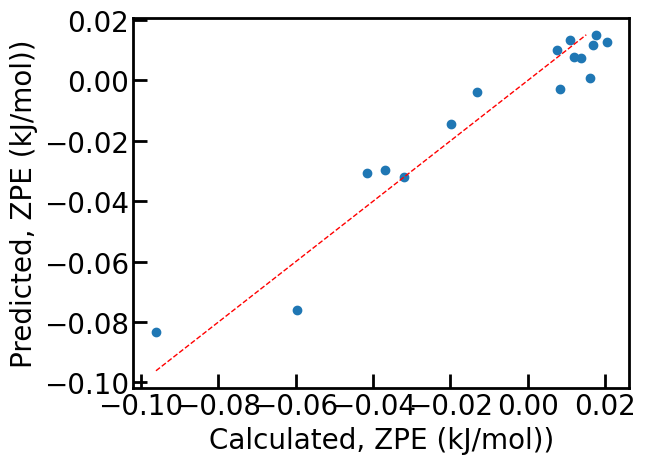

GB 0.9087654735609082
RMSE:  0.06424995281450087
RMSE unscaled:  0.009962875741078368
----------------------------------------


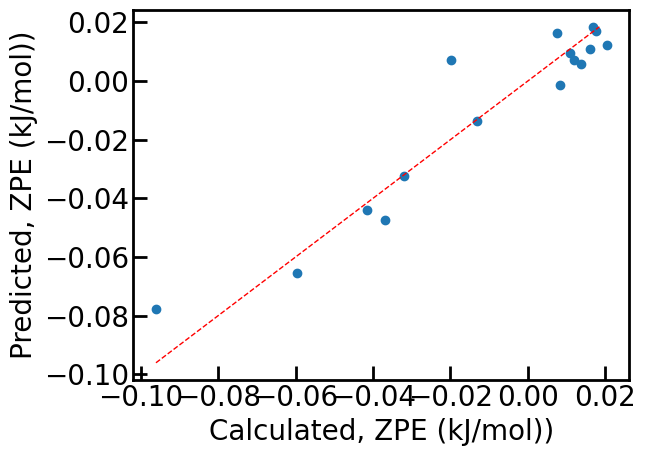

RR 0.9826639768141701
RMSE:  0.028007087070232563
RMSE unscaled:  0.004342900128750194
----------------------------------------


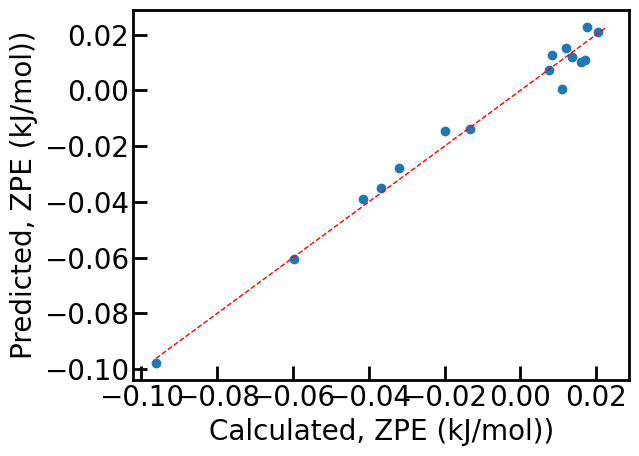

LASSO 0.6463114374718423
RMSE:  0.12650384038543327
RMSE unscaled:  0.019616232967019875
----------------------------------------


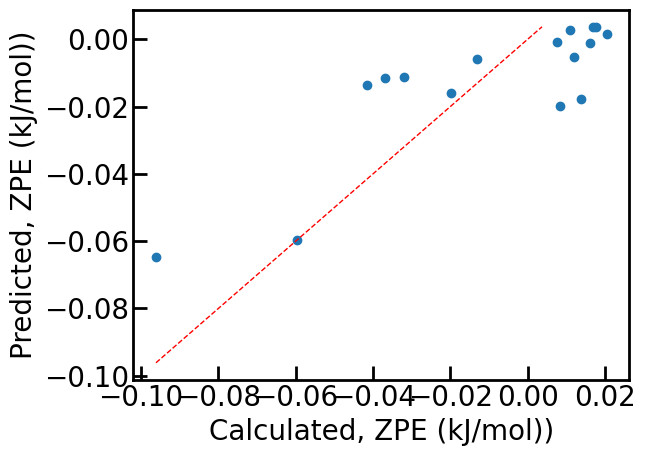

gpr1 0.9582482587215787
RMSE:  0.04346408069368305
RMSE unscaled:  0.006739728453989396
----------------------------------------


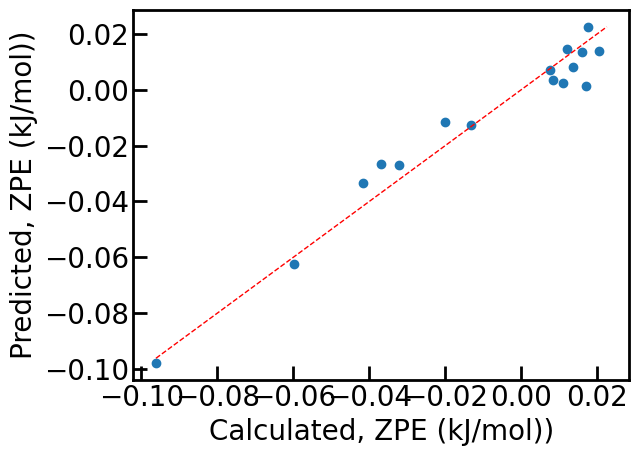

gpr2 -0.015673426427400328
RMSE:  0.21437307962384775
RMSE unscaled:  0.03324161747933085
----------------------------------------


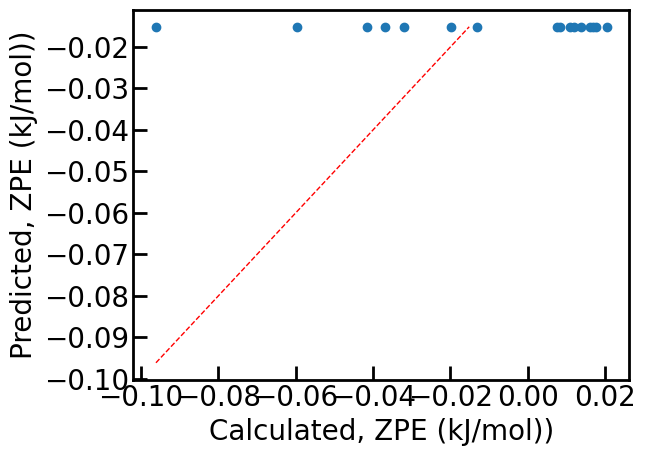

gpr3 0.9907582201784499
RMSE:  0.02044894989322846
RMSE unscaled:  0.003170902668364171
----------------------------------------


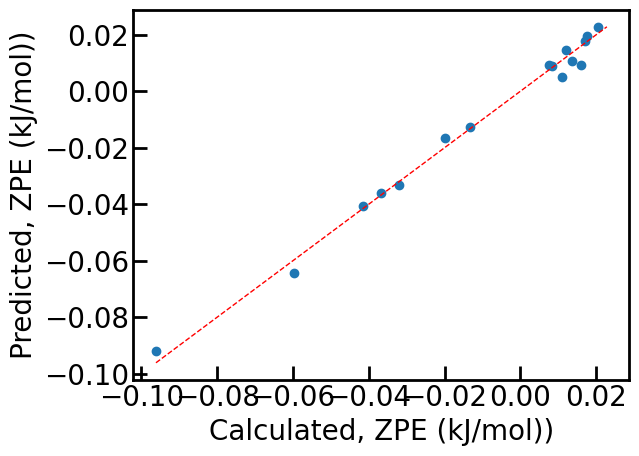

gpr4 0.974516170419761
RMSE:  0.03395670549559227
RMSE unscaled:  0.005265473710240995
----------------------------------------


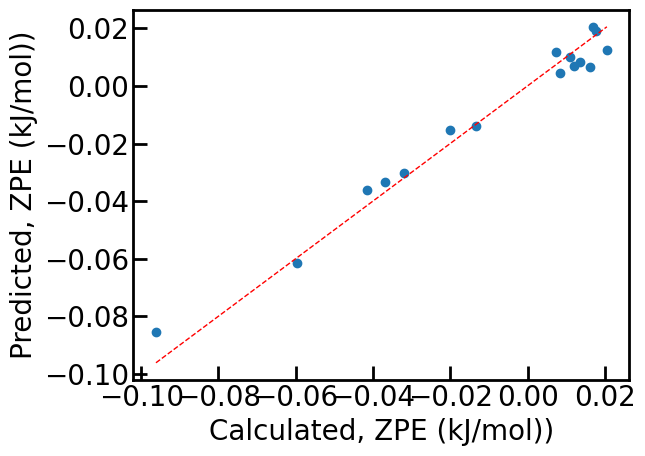

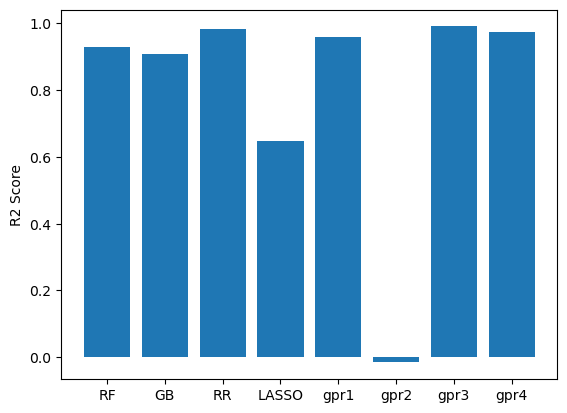

In [32]:
run_models()

## Feature selection


In [33]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  304.626316
14       X_Z  170.238631
4   mean_X2X  124.838656
2   mean_A2X   77.660541
23    X_IEII   75.077091
34    X_Rvdw   59.597995
32    A_Rvdw   36.345858
26      X_EA   35.663299
9      E_coh   34.613752
47   X_Kappa   32.665402
41     X_Rho   26.310545
46   B_Kappa   24.049675
18     A_IEI   20.916890
20     X_IEI   17.961665
30    A_ChiA   17.373147
25      B_EA   14.810073
43      X_MV   13.218705
29    X_ChiP   12.711918
6    std_A2X   12.381552
12       A_Z   10.101920
27    A_ChiP    9.324037
45   A_Kappa    7.987752
37      A_MP    7.760008
28    B_ChiP    6.612120
7    std_B2X    6.500297
13       B_Z    6.375766
38      B_MP    6.004889
48     A_CvM    5.906049
24      A_EA    5.775107
19     B_IEI    5.567722


In [34]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_IEII', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa', 'X_Rho', 'B_Kappa', 'A_IEI',
       'X_IEI', 'A_ChiA', 'B_EA', 'X_MV', 'X_ChiP', 'std_A2X', 'A_Z',
       'A_ChiP', 'A_Kappa', 'A_MP', 'B_ChiP', 'std_B2X', 'B_Z', 'B_MP',
       'A_CvM', 'A_EA', 'B_IEI', 'B_Hf', 'B_ChiA', 'B_Rho', 'density',
       'A_B', 'OF', 'A_G', 'TF', 'B_MV', 'std_A2B'], dtype=object)

In [35]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9337953677117984
RMSE:  0.05473150504788311
RMSE unscaled:  0.008486904036934877
----------------------------------------


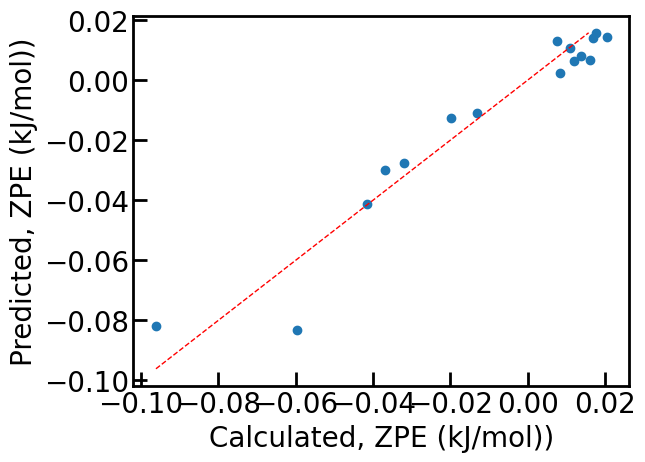

GB 0.9024907462264082
RMSE:  0.06642263779079564
RMSE unscaled:  0.01029978167633763
----------------------------------------


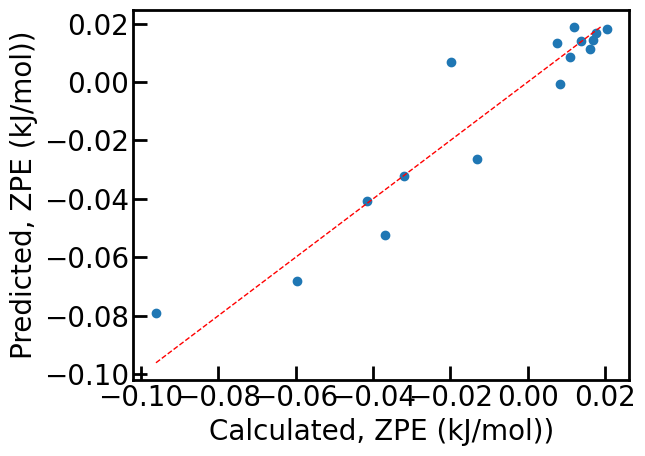

RR 0.9823386812973965
RMSE:  0.02826863027572538
RMSE unscaled:  0.004383456150087229
----------------------------------------


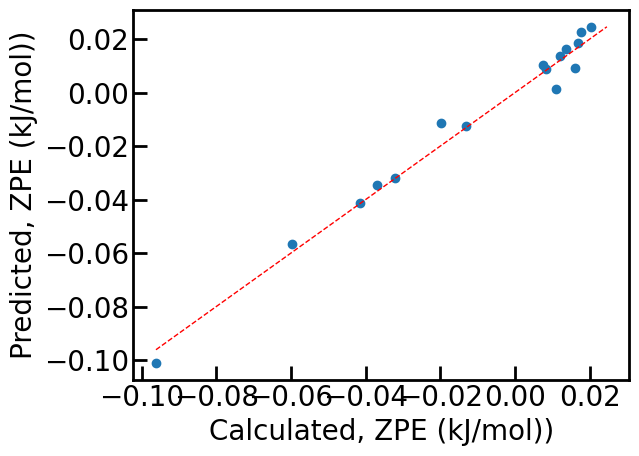

LASSO 0.6463060051695125
RMSE:  0.12650481186789125
RMSE unscaled:  0.01961638360929414
----------------------------------------


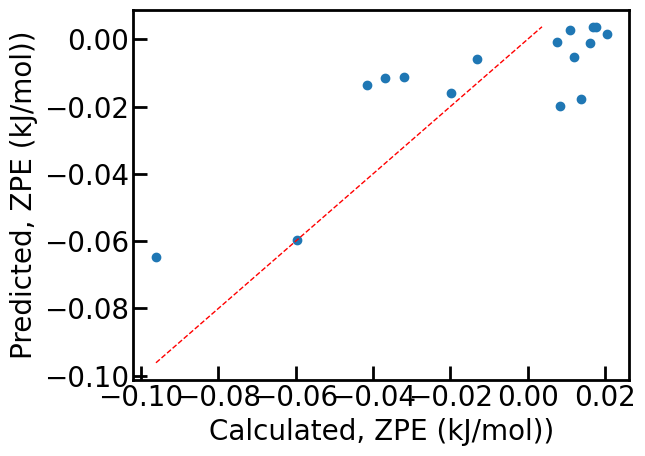

gpr1 0.9405878694348345
RMSE:  0.05184785159735257
RMSE unscaled:  0.0080397522531676
----------------------------------------


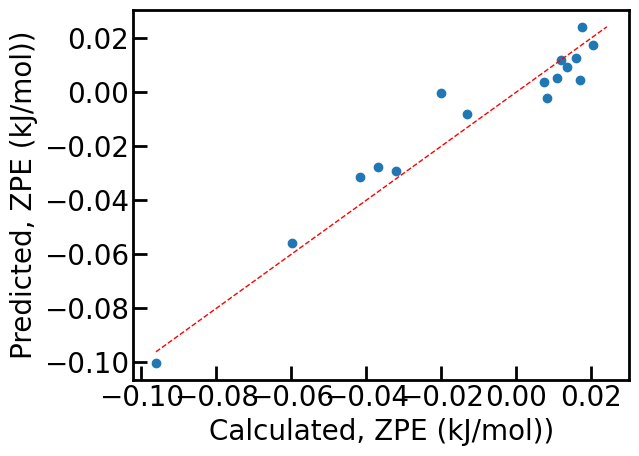

gpr2 -0.015673426502664123
RMSE:  0.2143730796317905
RMSE unscaled:  0.033241617480562494
----------------------------------------


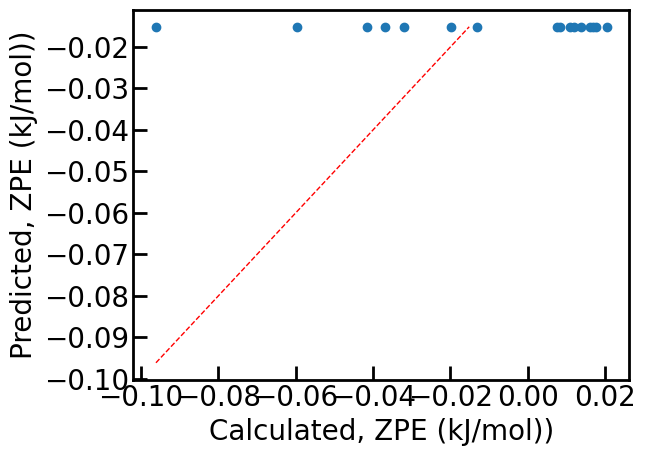

gpr3 0.9891387737306697
RMSE:  0.022168312383482863
RMSE unscaled:  0.0034375144570721254
----------------------------------------


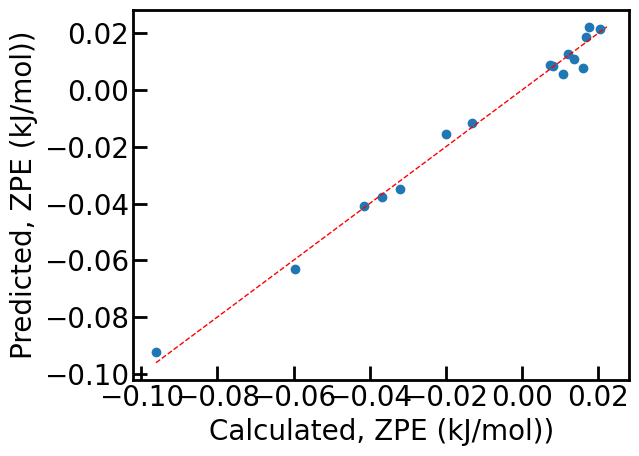

gpr4 0.97645460090772
RMSE:  0.032639705384204146
RMSE unscaled:  0.0050612539733233845
----------------------------------------


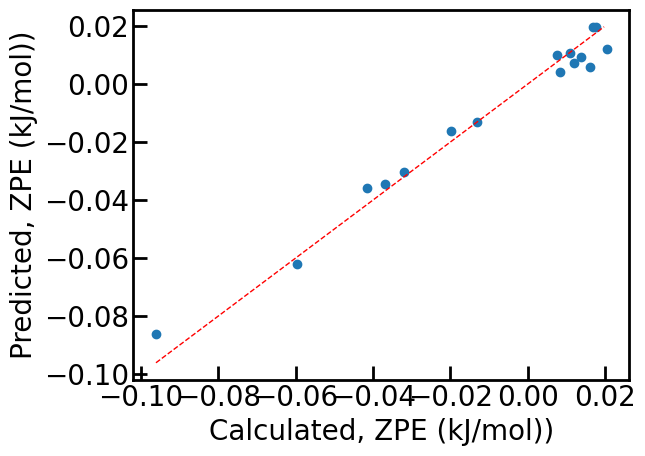

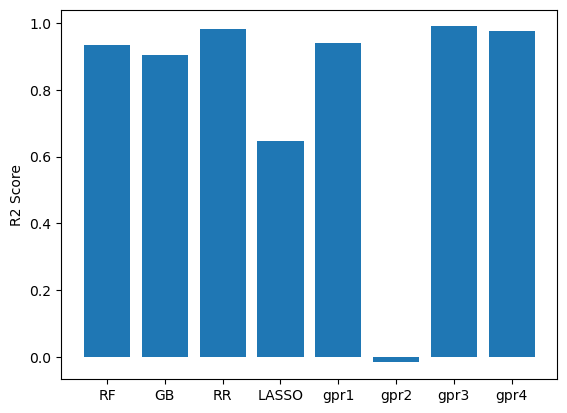

In [36]:
run_models()

In [37]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_IEII', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa', 'X_Rho', 'B_Kappa', 'A_IEI',
       'X_IEI', 'A_ChiA', 'B_EA', 'X_MV', 'X_ChiP', 'std_A2X', 'A_Z',
       'A_ChiP', 'A_Kappa', 'A_MP', 'B_ChiP', 'std_B2X', 'B_Z', 'B_MP',
       'A_CvM', 'A_EA', 'B_IEI'], dtype=object)

In [38]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.901638411747132
RMSE:  0.06671230837429769
RMSE unscaled:  0.010344699250637
----------------------------------------


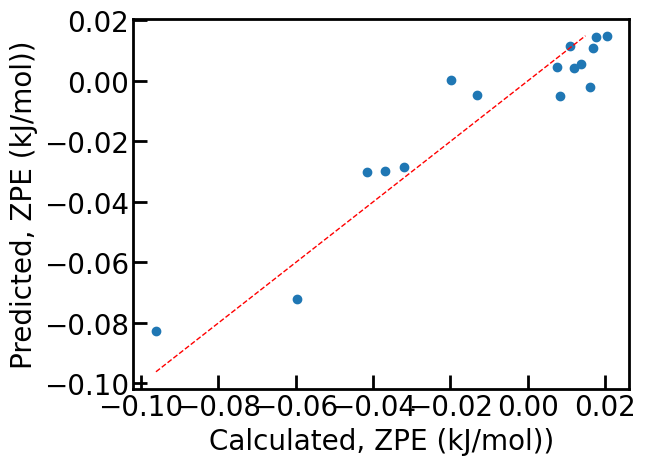

GB 0.8931718137918501
RMSE:  0.06952422067085517
RMSE unscaled:  0.010780726540591519
----------------------------------------


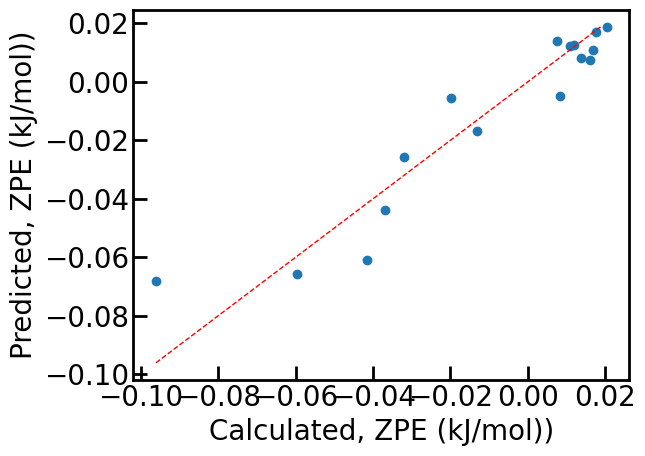

RR 0.9767257014048518
RMSE:  0.03245125543024665
RMSE unscaled:  0.0050320321078986575
----------------------------------------


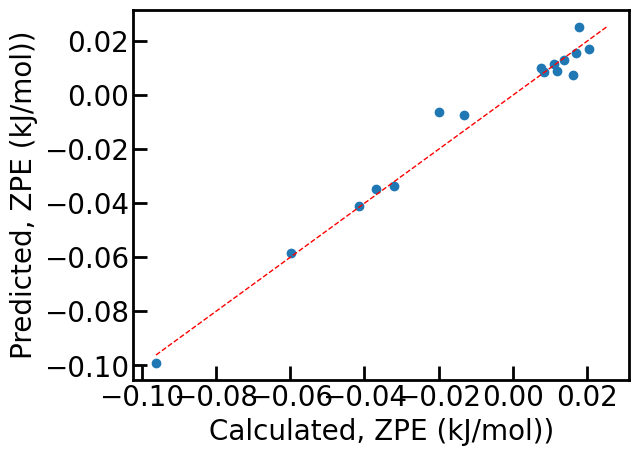

LASSO 0.6463060051695125
RMSE:  0.12650481186789125
RMSE unscaled:  0.01961638360929414
----------------------------------------


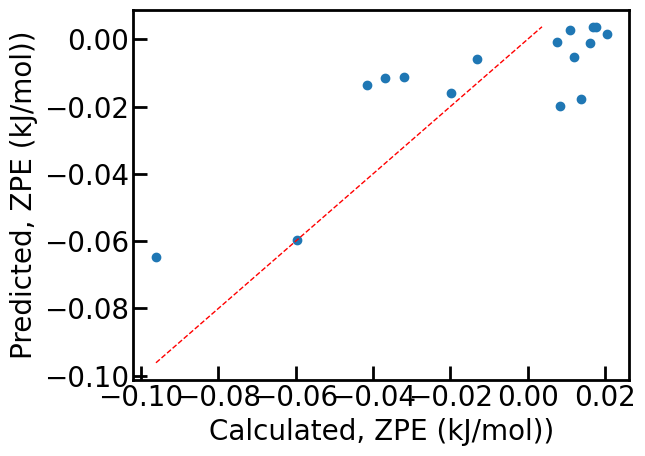

gpr1 0.9531599054050165
RMSE:  0.046036477257152486
RMSE unscaled:  0.007138615397807334
----------------------------------------


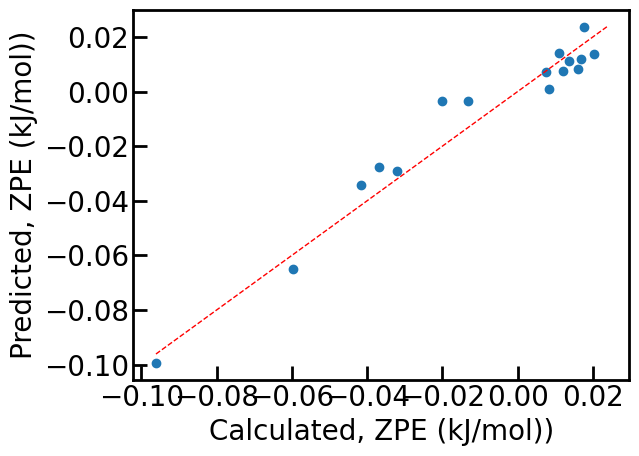

gpr2 -0.015673426564766002
RMSE:  0.21437307963834426
RMSE unscaled:  0.03324161748157874
----------------------------------------


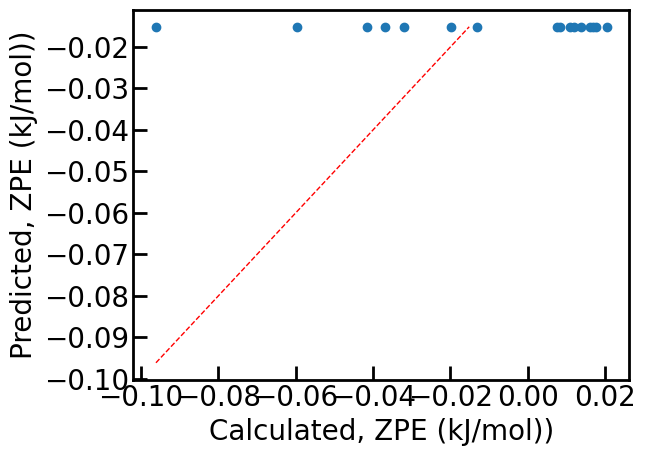

gpr3 0.9837724810512353
RMSE:  0.027096878527746077
RMSE unscaled:  0.00420175925299823
----------------------------------------


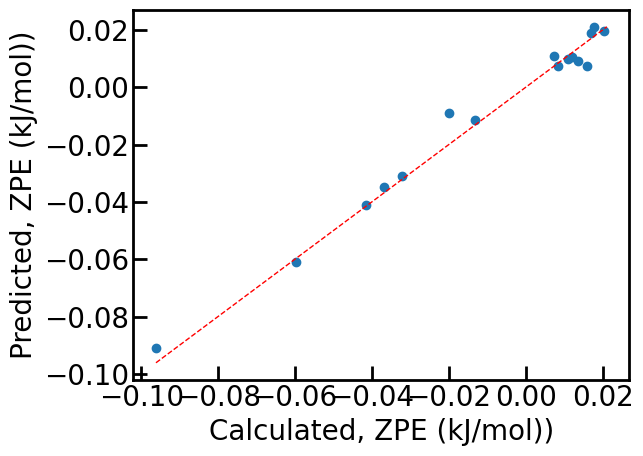

gpr4 0.971972004170247
RMSE:  0.03561141447630578
RMSE unscaled:  0.005522060045955384
----------------------------------------


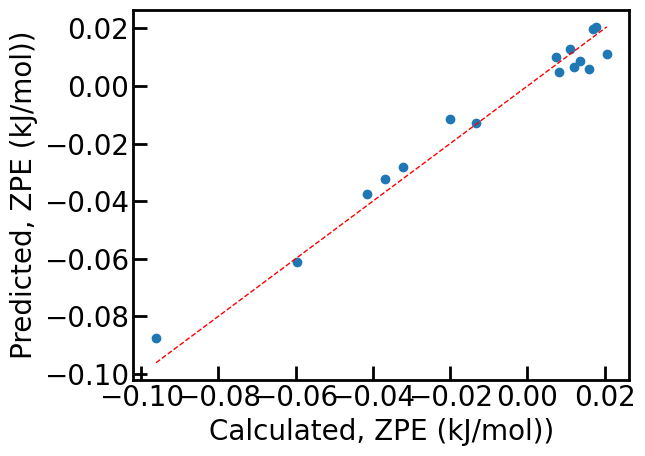

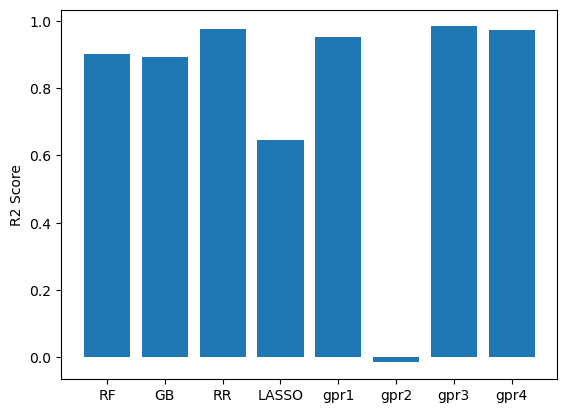

In [39]:
run_models()

In [40]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_IEII', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa', 'X_Rho', 'B_Kappa', 'A_IEI',
       'X_IEI', 'A_ChiA', 'B_EA', 'X_MV', 'X_ChiP', 'std_A2X', 'A_Z'],
      dtype=object)

In [41]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.937899320184758
RMSE:  0.05300799519740615
RMSE unscaled:  0.008219649140602083
----------------------------------------


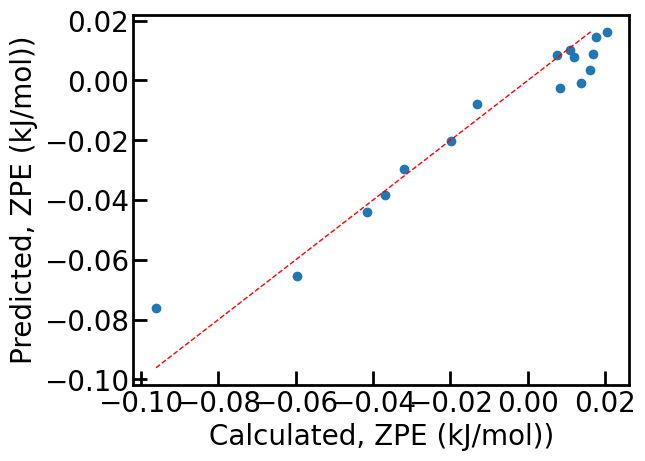

GB 0.8815854751457716
RMSE:  0.07319740594968871
RMSE unscaled:  0.011350306546550955
----------------------------------------


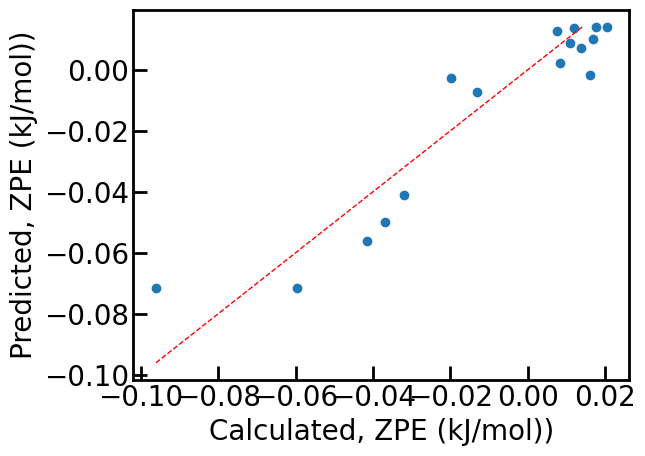

RR 0.9577266254062159
RMSE:  0.04373475127597807
RMSE unscaled:  0.006781699805874373
----------------------------------------


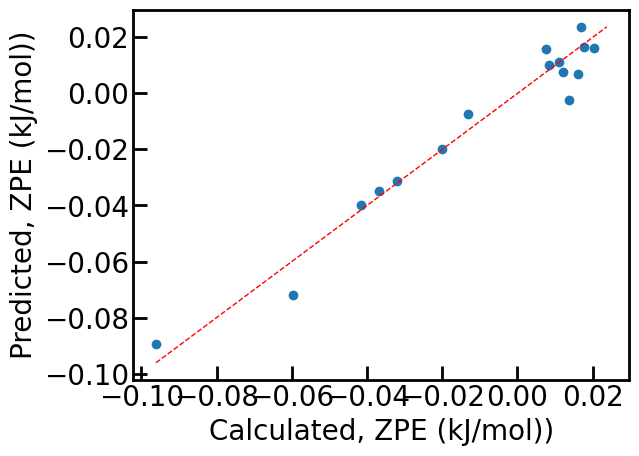

LASSO 0.6463060051695125
RMSE:  0.12650481186789125
RMSE unscaled:  0.01961638360929414
----------------------------------------


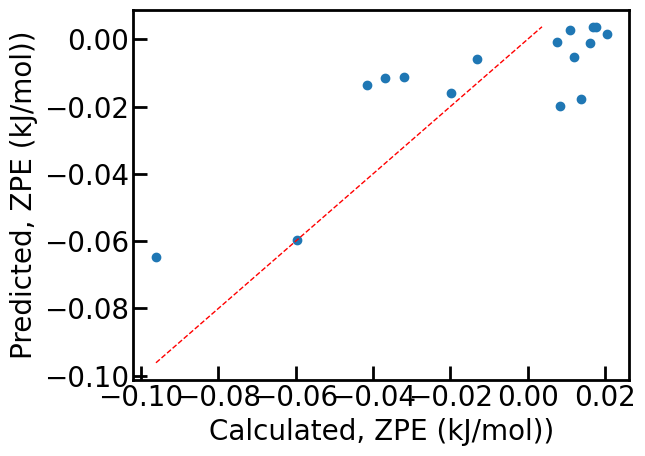

gpr1 0.9440237316937405
RMSE:  0.05032631982931915
RMSE unscaled:  0.007803816952408919
----------------------------------------


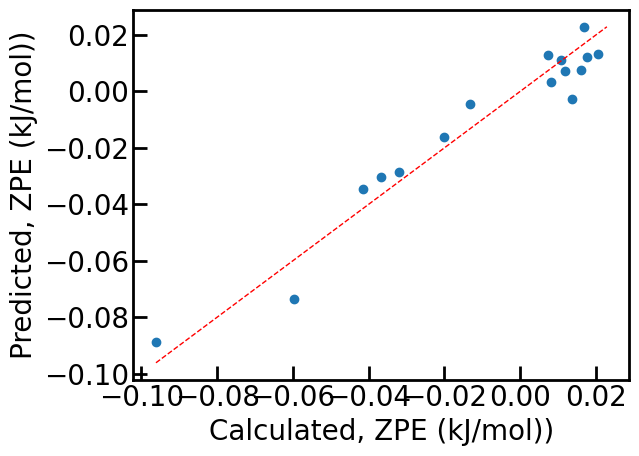

gpr2 -0.015673428738218753
RMSE:  0.21437307986771412
RMSE unscaled:  0.03324161751714583
----------------------------------------


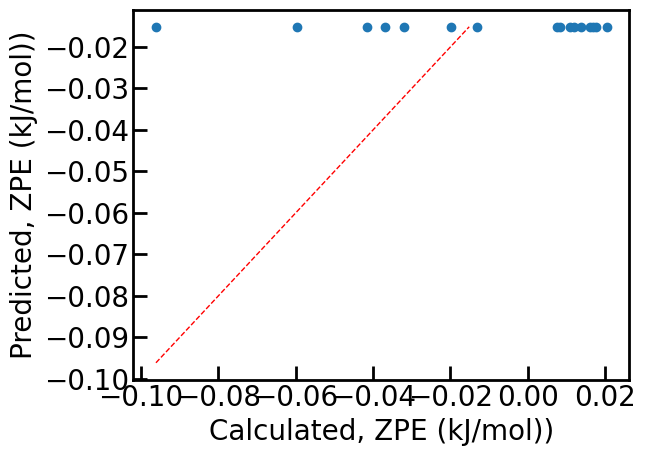

gpr3 0.9690678409141147
RMSE:  0.03741091406887735
RMSE unscaled:  0.0058010982405618935
----------------------------------------


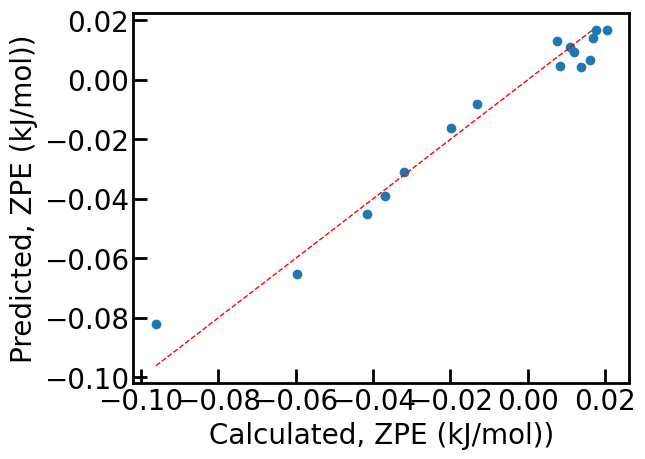

gpr4 0.9548844330921182
RMSE:  0.04518105955245074
RMSE unscaled:  0.0070059706264832605
----------------------------------------


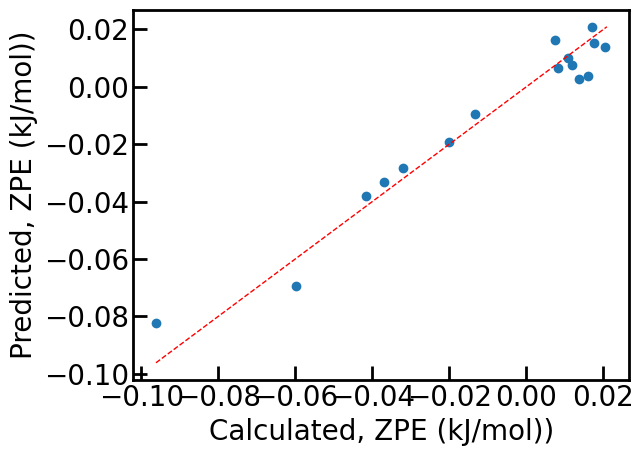

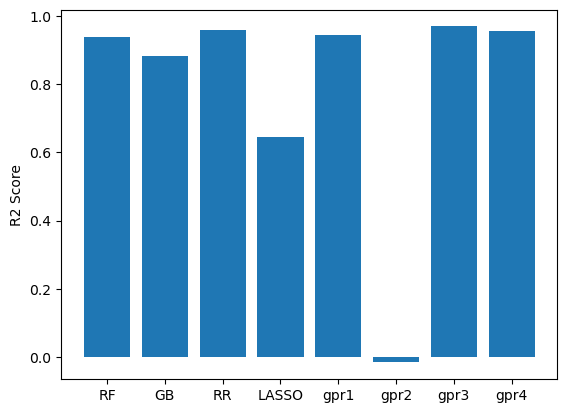

In [42]:
run_models()

In [43]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_Z', 'mean_X2X', 'mean_A2X', 'X_IEII', 'X_Rvdw',
       'A_Rvdw', 'X_EA', 'E_coh', 'X_Kappa'], dtype=object)

In [44]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9192489988350464
RMSE:  0.06044594334144368
RMSE unscaled:  0.009373009569388354
----------------------------------------


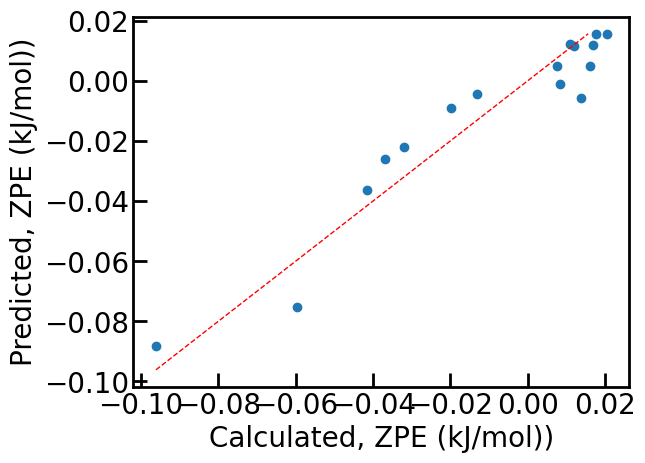

GB 0.8959061071032207
RMSE:  0.06862870867863204
RMSE unscaled:  0.01064186457552637
----------------------------------------


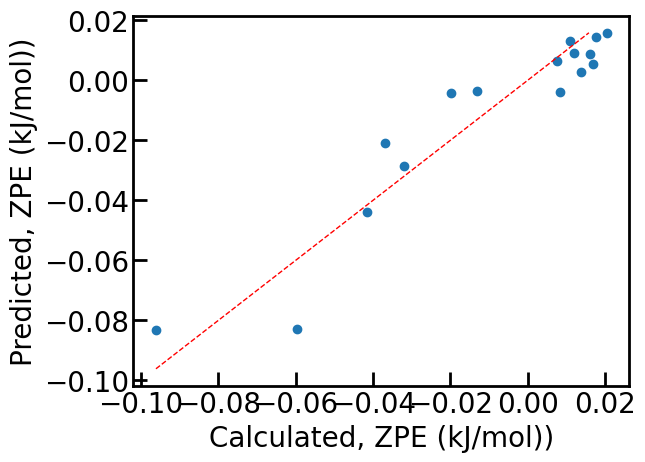

RR 0.8022721378012128
RMSE:  0.09458606047629756
RMSE unscaled:  0.014666923882172772
----------------------------------------


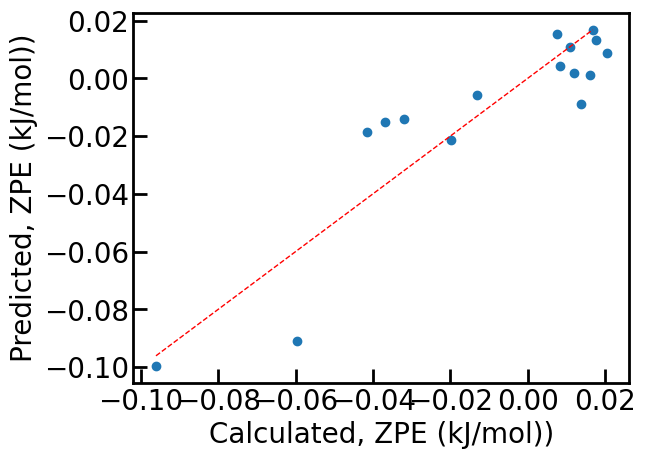

LASSO 0.6463060051695125
RMSE:  0.12650481186789125
RMSE unscaled:  0.01961638360929414
----------------------------------------


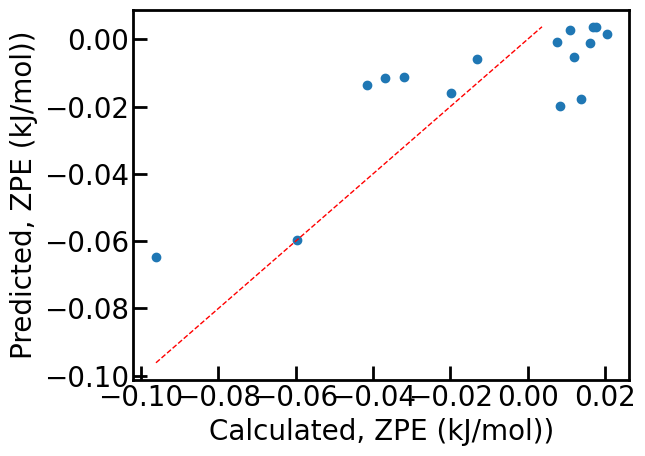

gpr1 0.7555685646389582
RMSE:  0.10516512224859824
RMSE unscaled:  0.01630735898410854
----------------------------------------


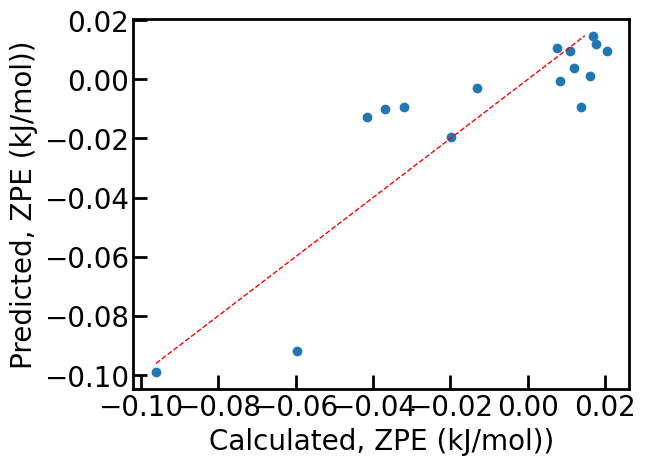

gpr2 -0.015673426413669755
RMSE:  0.2143730796223987
RMSE unscaled:  0.03324161747910616
----------------------------------------


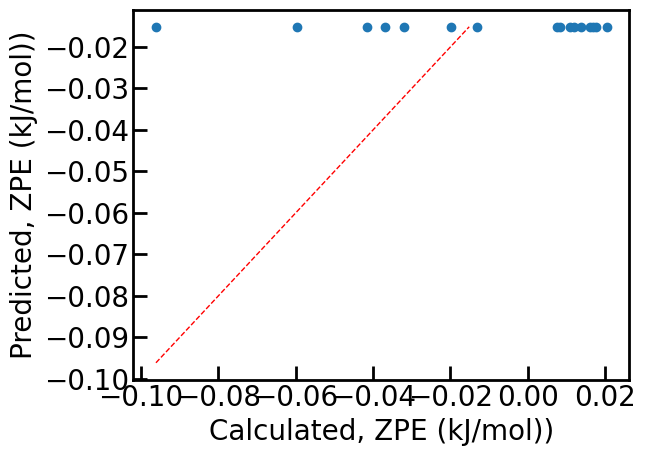

gpr3 0.917626434268876
RMSE:  0.061050206167021864
RMSE unscaled:  0.009466709178220277
----------------------------------------


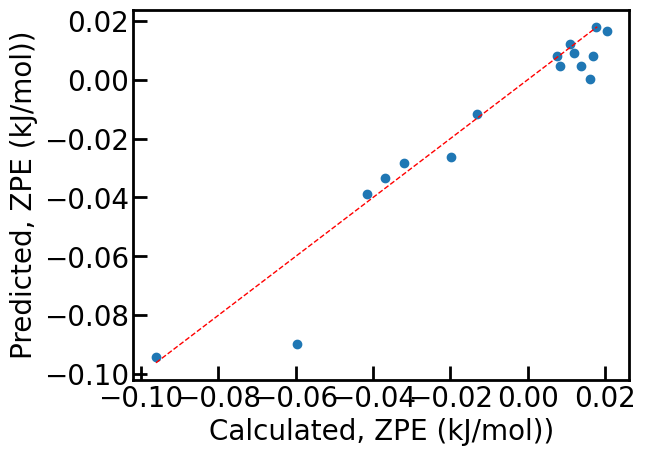

gpr4 0.8327516740444423
RMSE:  0.08699095361625277
RMSE unscaled:  0.013489193742738957
----------------------------------------


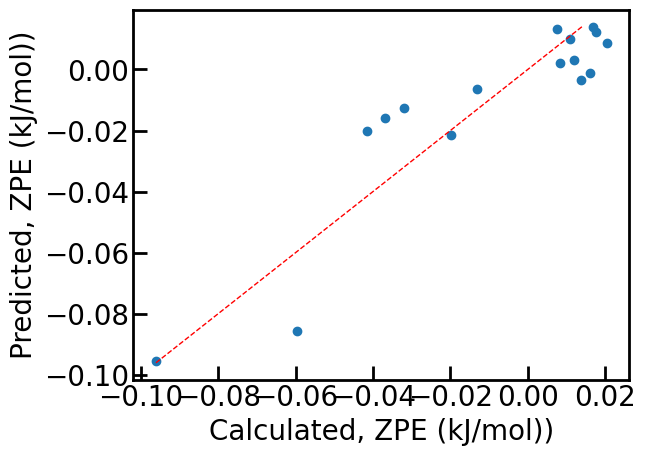

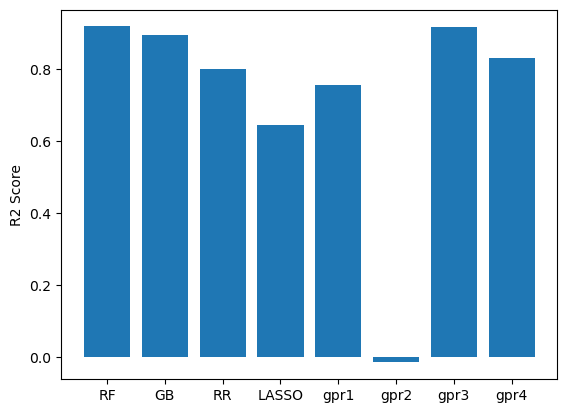

In [45]:
run_models()